# Meta-analytic functional decoding

## Continuous decoding

In this notebook, we applied meta-analytic functional decoding using the [NiMARE](https://nimare.readthedocs.io/en/stable/decoding.html). 

Specifically, we applied a continuous, correlation-based decoding approach to unthresholded meta-analytic statistical maps, assessing their similarity to term-based meta-analytic maps derived from large-scale databases such as Neurosynth.

In [1]:
# Import necessary modules
import os
import sys
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

import nibabel as nib

from nilearn import image, plotting, datasets
from nilearn.maskers import NiftiSpheresMasker

import nimare
from nimare.dataset import Dataset
from nimare.decode import discrete, continuous
from nimare.stats import pearson
from nimare.extract import fetch_neurosynth
from nimare.io import convert_neurosynth_to_dataset
from nilearn.masking import _unmask_3d

# print the current working directory
# print(os.getcwd())

In [3]:
# get neurosynth data
databases = nimare.extract.fetch_neurosynth(data_dir='../1_Data/AnalysisData')[0]

# convert to NiMARE dataset (Note: This can take a while!)
ds = nimare.io.convert_neurosynth_to_dataset(
    coordinates_file=databases['coordinates'],
    metadata_file=databases['metadata'],
    annotations_files=databases['features']
    )

INFO:nimare.extract.utils:Dataset created in ../1_Data/AnalysisData/neurosynth
INFO:nimare.extract.extract:Searching for any feature files matching the following criteria: [('data-neurosynth', 'version-7')]


In [6]:
# fetch cognitive atlas terms

base_url = "https://www.cognitiveatlas.org/api/v-alpha"

# Fetch concepts and tasks from Cognitive Atlas API
concepts = requests.get(f"{base_url}/concept?format=json").json()
tasks = requests.get(f"{base_url}/task?format=json").json()

# Collect term names (lowercase for matching)
cognitive_terms = [c["name"].lower() for c in concepts] + \
                  [t["name"].lower() for t in tasks]

print(f"Fetched {len(cognitive_terms)} cognitive terms from Cognitive Atlas.")


Fetched 1774 cognitive terms from Cognitive Atlas.


In [ ]:
# filter nimare annotations
# keep study identifier plus cognitive atlas–matched terms
terms_to_keep = ["id"] + [
    col for col in ds.annotations.columns
    if col.split("__")[-1].lower() in cognitive_terms
]

ds.annotations = ds.annotations[terms_to_keep]

print(f"Remaining features after filtering: {len(ds.annotations.columns) - 1}")

Remaining features after filtering: 133


In [ ]:
# ensure required identifier columns exist

if "study_id" not in ds.annotations.columns:
    ds.annotations["study_id"] = ds.annotations["id"]

if "contrast_id" not in ds.annotations.columns:
    ds.annotations["contrast_id"] = ds.annotations["id"]


In [ ]:
# Continuous functional decoding
# zmap_path = ("../3_Output/1_ALE/heper_and_hypo_z.nii.gz")

zmap_path = ("../3_Output/1_ALE/heper_and_hypo_z.nii.gz")
print(f"Running continuous decoding for:\n{zmap_path}")

In [ ]:
target_img = nib.load(zmap_path)


In [ ]:
# define decoder parameters

decoder = continuous.CorrelationDecoder(
    frequency_threshold=0.001
)

decoder.fit(ds)
pat_minus_con_results = decoder.transform(target_img)
pat_minus_con_results.head()

pat_minus_con_results.to_csv("/Volumes/ss/Self_Psych_Meta/3_Output/4_Decoding/heper_and_hypo.csv", index=True)

# Visualization 


## Plot radar figure


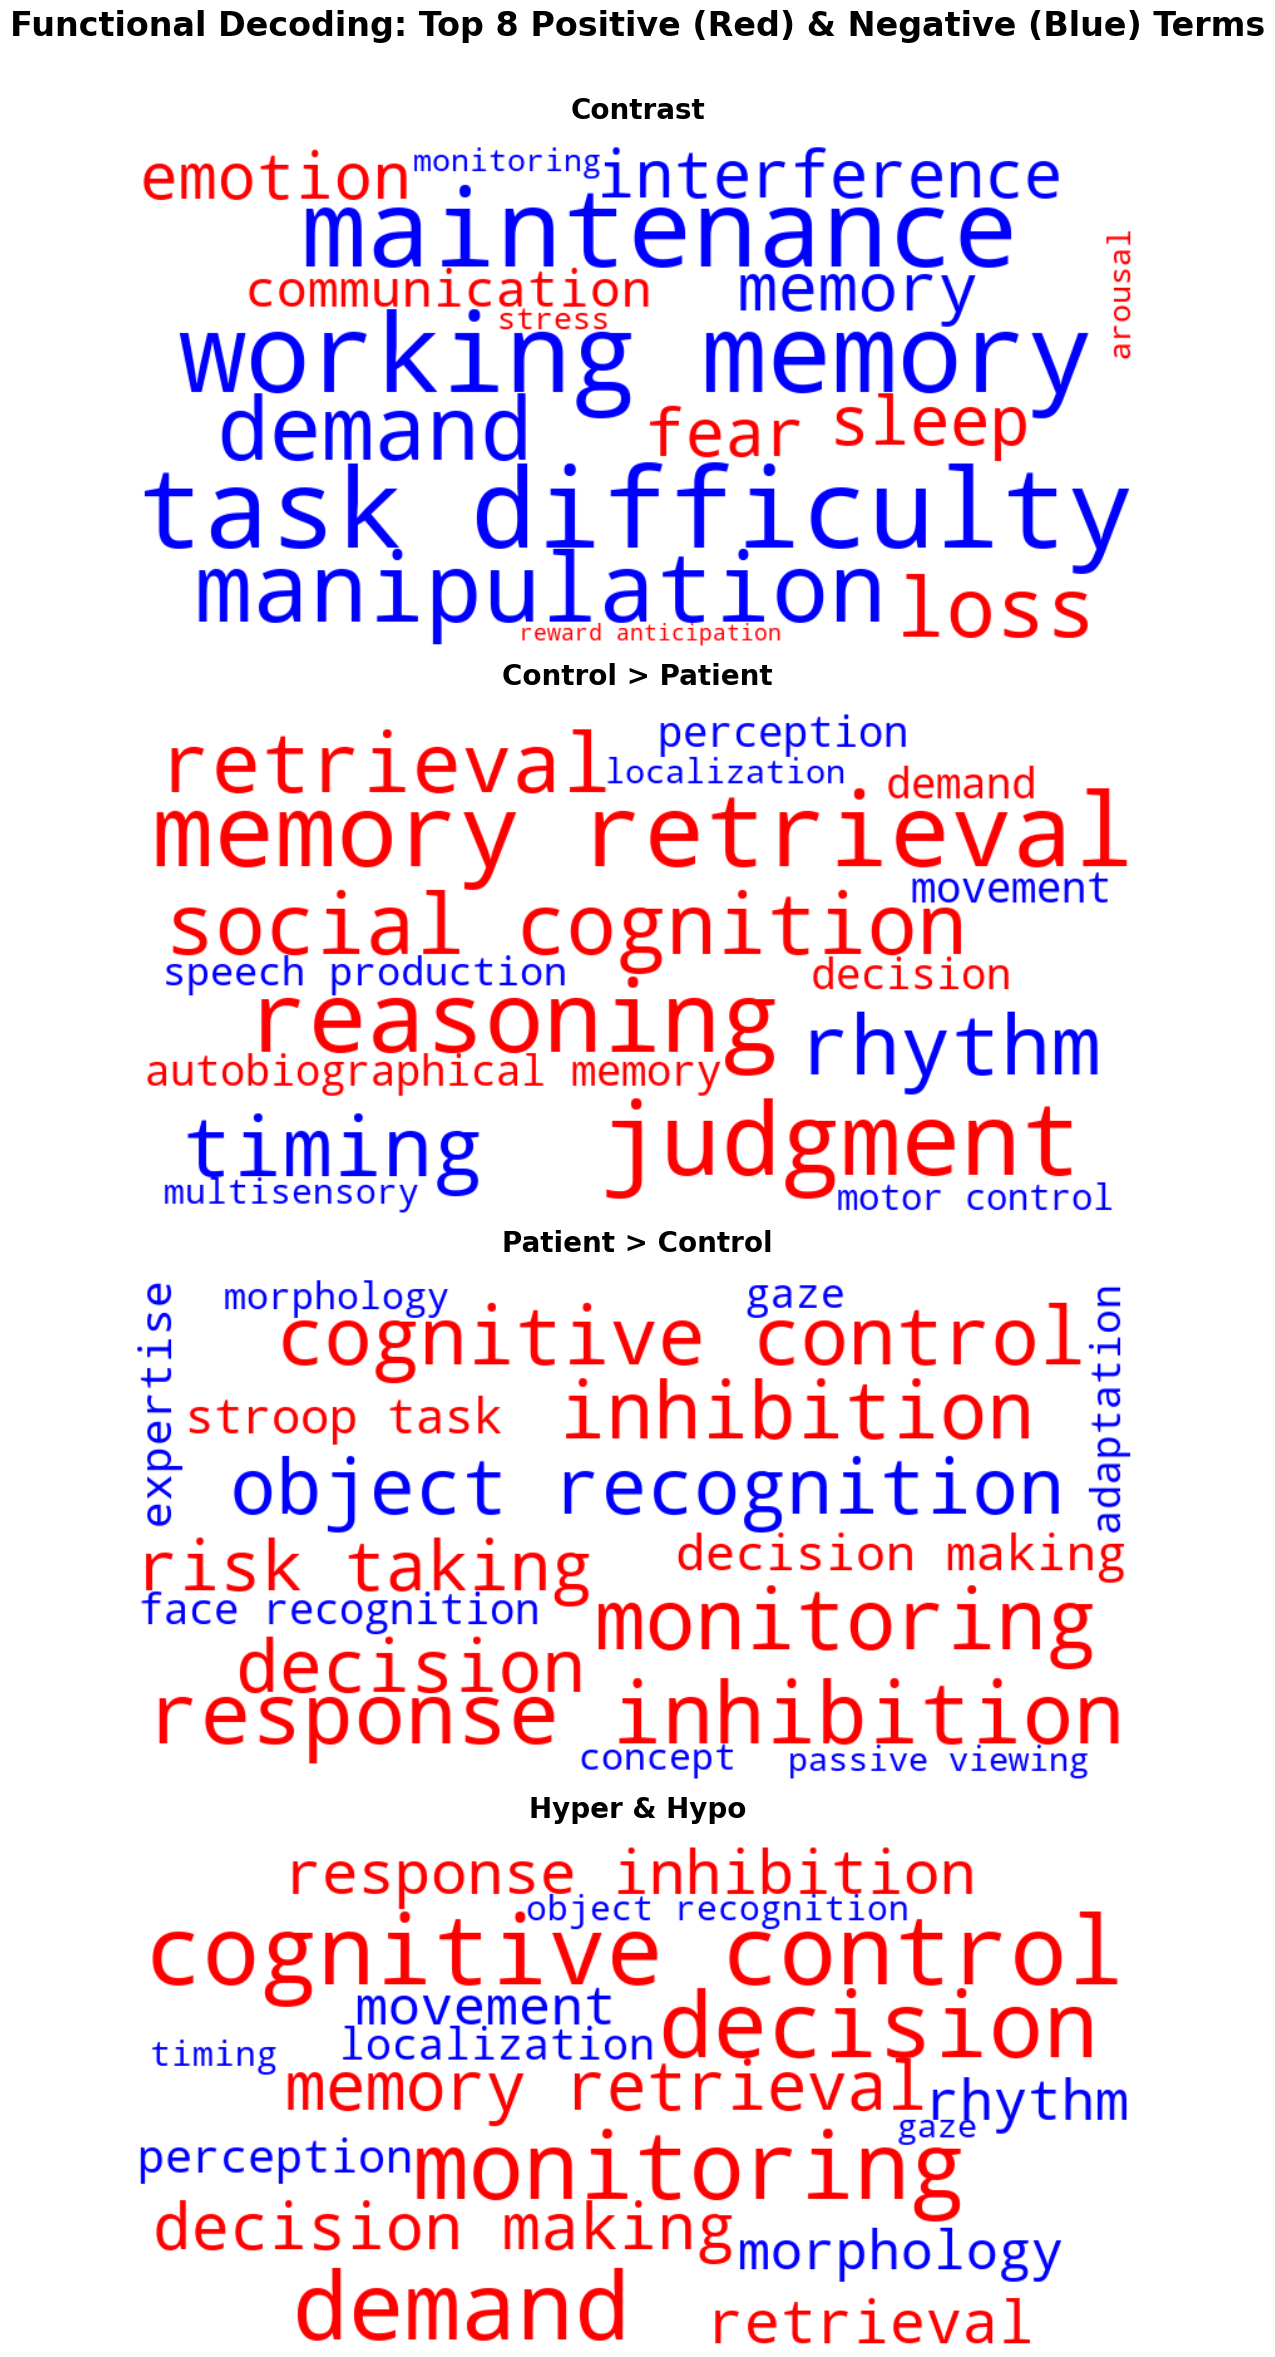

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

files = [
    '/Volumes/ss/Self_Psych_Meta/3_Output/4_Decoding/contrast.csv', 
    '/Volumes/ss/Self_Psych_Meta/3_Output/4_Decoding/control_minus_patient.csv', 
    '/Volumes/ss/Self_Psych_Meta/3_Output/4_Decoding/patient_minus_control.csv', 
    '/Volumes/ss/Self_Psych_Meta/3_Output/4_Decoding/heper_and_hypo.csv'
]

titles = [
    'Contrast',
    'Control > Patient',
    'Patient > Control',
    'Hyper & Hypo'
]

# 调整布局为 2x2 可能会比 4x1 更美观，这里保持 4x1 按照你的要求
fig, axes = plt.subplots(4, 1, figsize=(12, 24))
axes = axes.flatten()

for i, file_name in enumerate(files):
    df = pd.read_csv(file_name)
    df['feature'] = df['feature'].str.replace('terms_abstract_tfidf__', '', regex=False)
    
    # 1. 筛选正相关前 8 和负相关前 8
    pos_top8 = df.sort_values(by='r', ascending=False).head(8)
    neg_top8 = df.sort_values(by='r', ascending=True).head(8)
    
    # 合并数据
    combined_df = pd.concat([pos_top8, neg_top8])
    
    # 2. 构建字号权重（必须为正数）和颜色映射字典
    # 使用绝对值来决定大小
    word_freq = dict(zip(combined_df['feature'], combined_df['r'].abs()))
    # 记录原始正负号用于着色
    word_color_map = dict(zip(combined_df['feature'], combined_df['r']))
    
    # 3. 定义颜色函数
    def color_func(word, *args, **kwargs):
        if word_color_map.get(word, 0) > 0:
            return "red"     # 正相关为红
        else:
            return "blue"    # 负相关为蓝

    # 4. 生成词云
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=16,         # 8正 + 8负
        color_func=color_func,
        prefer_horizontal=0.8,
        random_state=42,
        relative_scaling=0.5
    ).generate_from_frequencies(word_freq)
    
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(titles[i], fontsize=20, fontweight='bold', pad=20)
    axes[i].axis('off')

plt.suptitle("Functional Decoding: Top 8 Positive (Red) & Negative (Blue) Terms", 
             fontsize=24, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

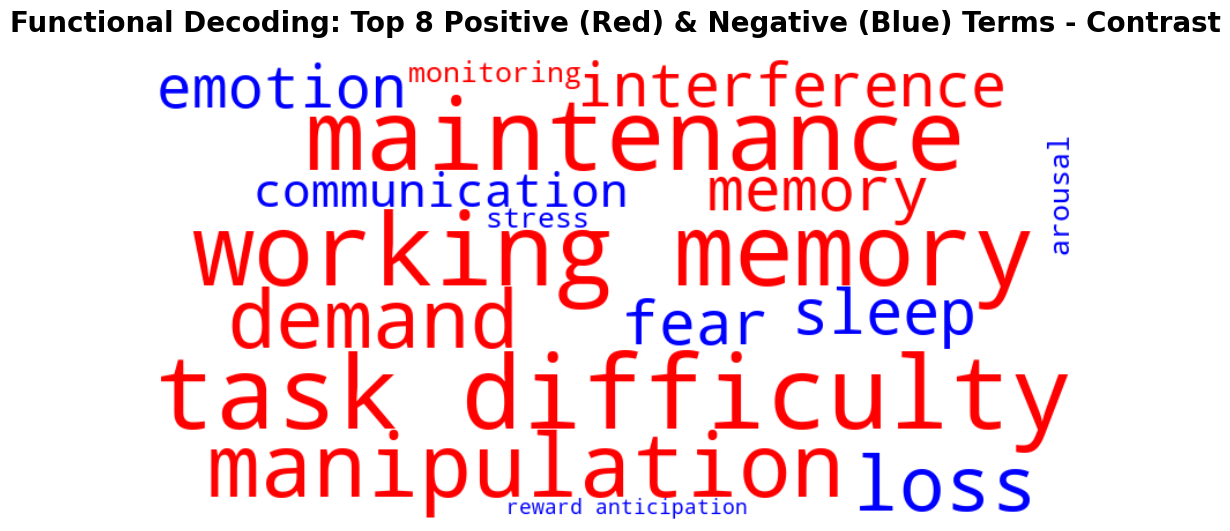

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 只保留 contrast 文件
file_name = '/Volumes/ss/Self_Psych_Meta/3_Output/4_Decoding/contrast.csv'
title = 'Contrast'

# 读取数据
df = pd.read_csv(file_name)
df['feature'] = df['feature'].str.replace('terms_abstract_tfidf__', '', regex=False)

# 筛选正相关前 8 和负相关前 8
pos_top8 = df.sort_values(by='r', ascending=False).head(8)
neg_top8 = df.sort_values(by='r', ascending=True).head(8)

# 合并数据
combined_df = pd.concat([pos_top8, neg_top8])

# 构建词频和颜色映射
word_freq = dict(zip(combined_df['feature'], combined_df['r'].abs()))
word_color_map = dict(zip(combined_df['feature'], combined_df['r']))

# 定义颜色函数
def color_func(word, *args, **kwargs):
    return "blue" if word_color_map.get(word, 0) > 0 else "red"

# 生成词云
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=16,
    color_func=color_func,
    prefer_horizontal=0.8,
    random_state=42,
    relative_scaling=0.5
).generate_from_frequencies(word_freq)

# 绘图
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.title(f"Functional Decoding: Top 8 Positive (Red) & Negative (Blue) Terms - {title}", 
          fontsize=20, fontweight='bold', pad=20)
plt.axis('off')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_elegant_contrast_radar(main_file, output_name='Contrast'):
    # 1. 数据提取
    df_main = pd.read_csv(main_file)
    df_main['feature'] = df_main['feature'].str.replace('terms_abstract_tfidf__', '', regex=False)
    
    # 剔除解剖词
    exclude = ['triangularis', 'frontal', 'pars', 'gyrus', 'inferior', 'cortex', 'brain', 'area']
    df_clean = df_main[~df_main['feature'].str.contains('|'.join(exclude), case=False)]

    # 分别提取 Control 正向最强 和 Patient (负向) 最强
    # 注意：在 contrast.csv 中，负值代表 Patient > Control
    df_control = df_clean.sort_values(by='r', ascending=False).head(8)
    df_patient = df_clean.sort_values(by='r', ascending=True).head(8).copy()
    df_patient['abs_r'] = df_patient['r'].abs() # 取绝对值用于绘图

    # 合并标签并去重
    labels = list(dict.fromkeys(list(df_patient['feature']) + list(df_control['feature'])))
    num_vars = len(labels)

    # 准备两个序列的数据：对齐到相同的 labels 上
    # 如果某一组在某个标签上没有值，给一个极小值 0.005 保持图形圆润
    val_p = [dict(zip(df_patient['feature'], df_patient['abs_r'])).get(l, 0.005) for l in labels]
    val_c = [dict(zip(df_control['feature'], df_control['r'])).get(l, 0.005) for l in labels]

    # 闭合环路
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    val_p += val_p[:1]
    val_c += val_c[:1]
    angles += angles[:1]

    # 2. 绘图设置
    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # 莫兰迪配色 (淡红与淡蓝)
    p_color = '#FB9A99' # 淡红 (Patient)
    c_color = '#A6CEE3' # 淡蓝 (Control)

    # 绘制层叠序列
    # Patient 序列
    ax.plot(angles, val_p, color='#E31A1C', linewidth=1.2, alpha=0.7)
    ax.fill(angles, val_p, color=p_color, alpha=0.4, label='Patient')

    # Control 序列
    ax.plot(angles, val_c, color='#1F78B4', linewidth=1.2, alpha=0.7)
    ax.fill(angles, val_c, color=c_color, alpha=0.4, label='Control')

    # 3. 视觉精修
    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=10, fontweight='500')
    
    # 隐藏不必要的元素，让图更清爽

    # ax.grid(color='#EEEEEE', linestyle='-', linewidth=0.5) # 极淡网格
    ax.grid(True, linestyle='--', alpha=0.3)

    # 设置图例在下方
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), frameon=False, ncol=2, fontsize=11)
    
    plt.tight_layout()
    plt.savefig(f"{output_name}.png", dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
# 运行代码
plot_elegant_contrast_radar('../Output/4_Decoding/contrast.csv')

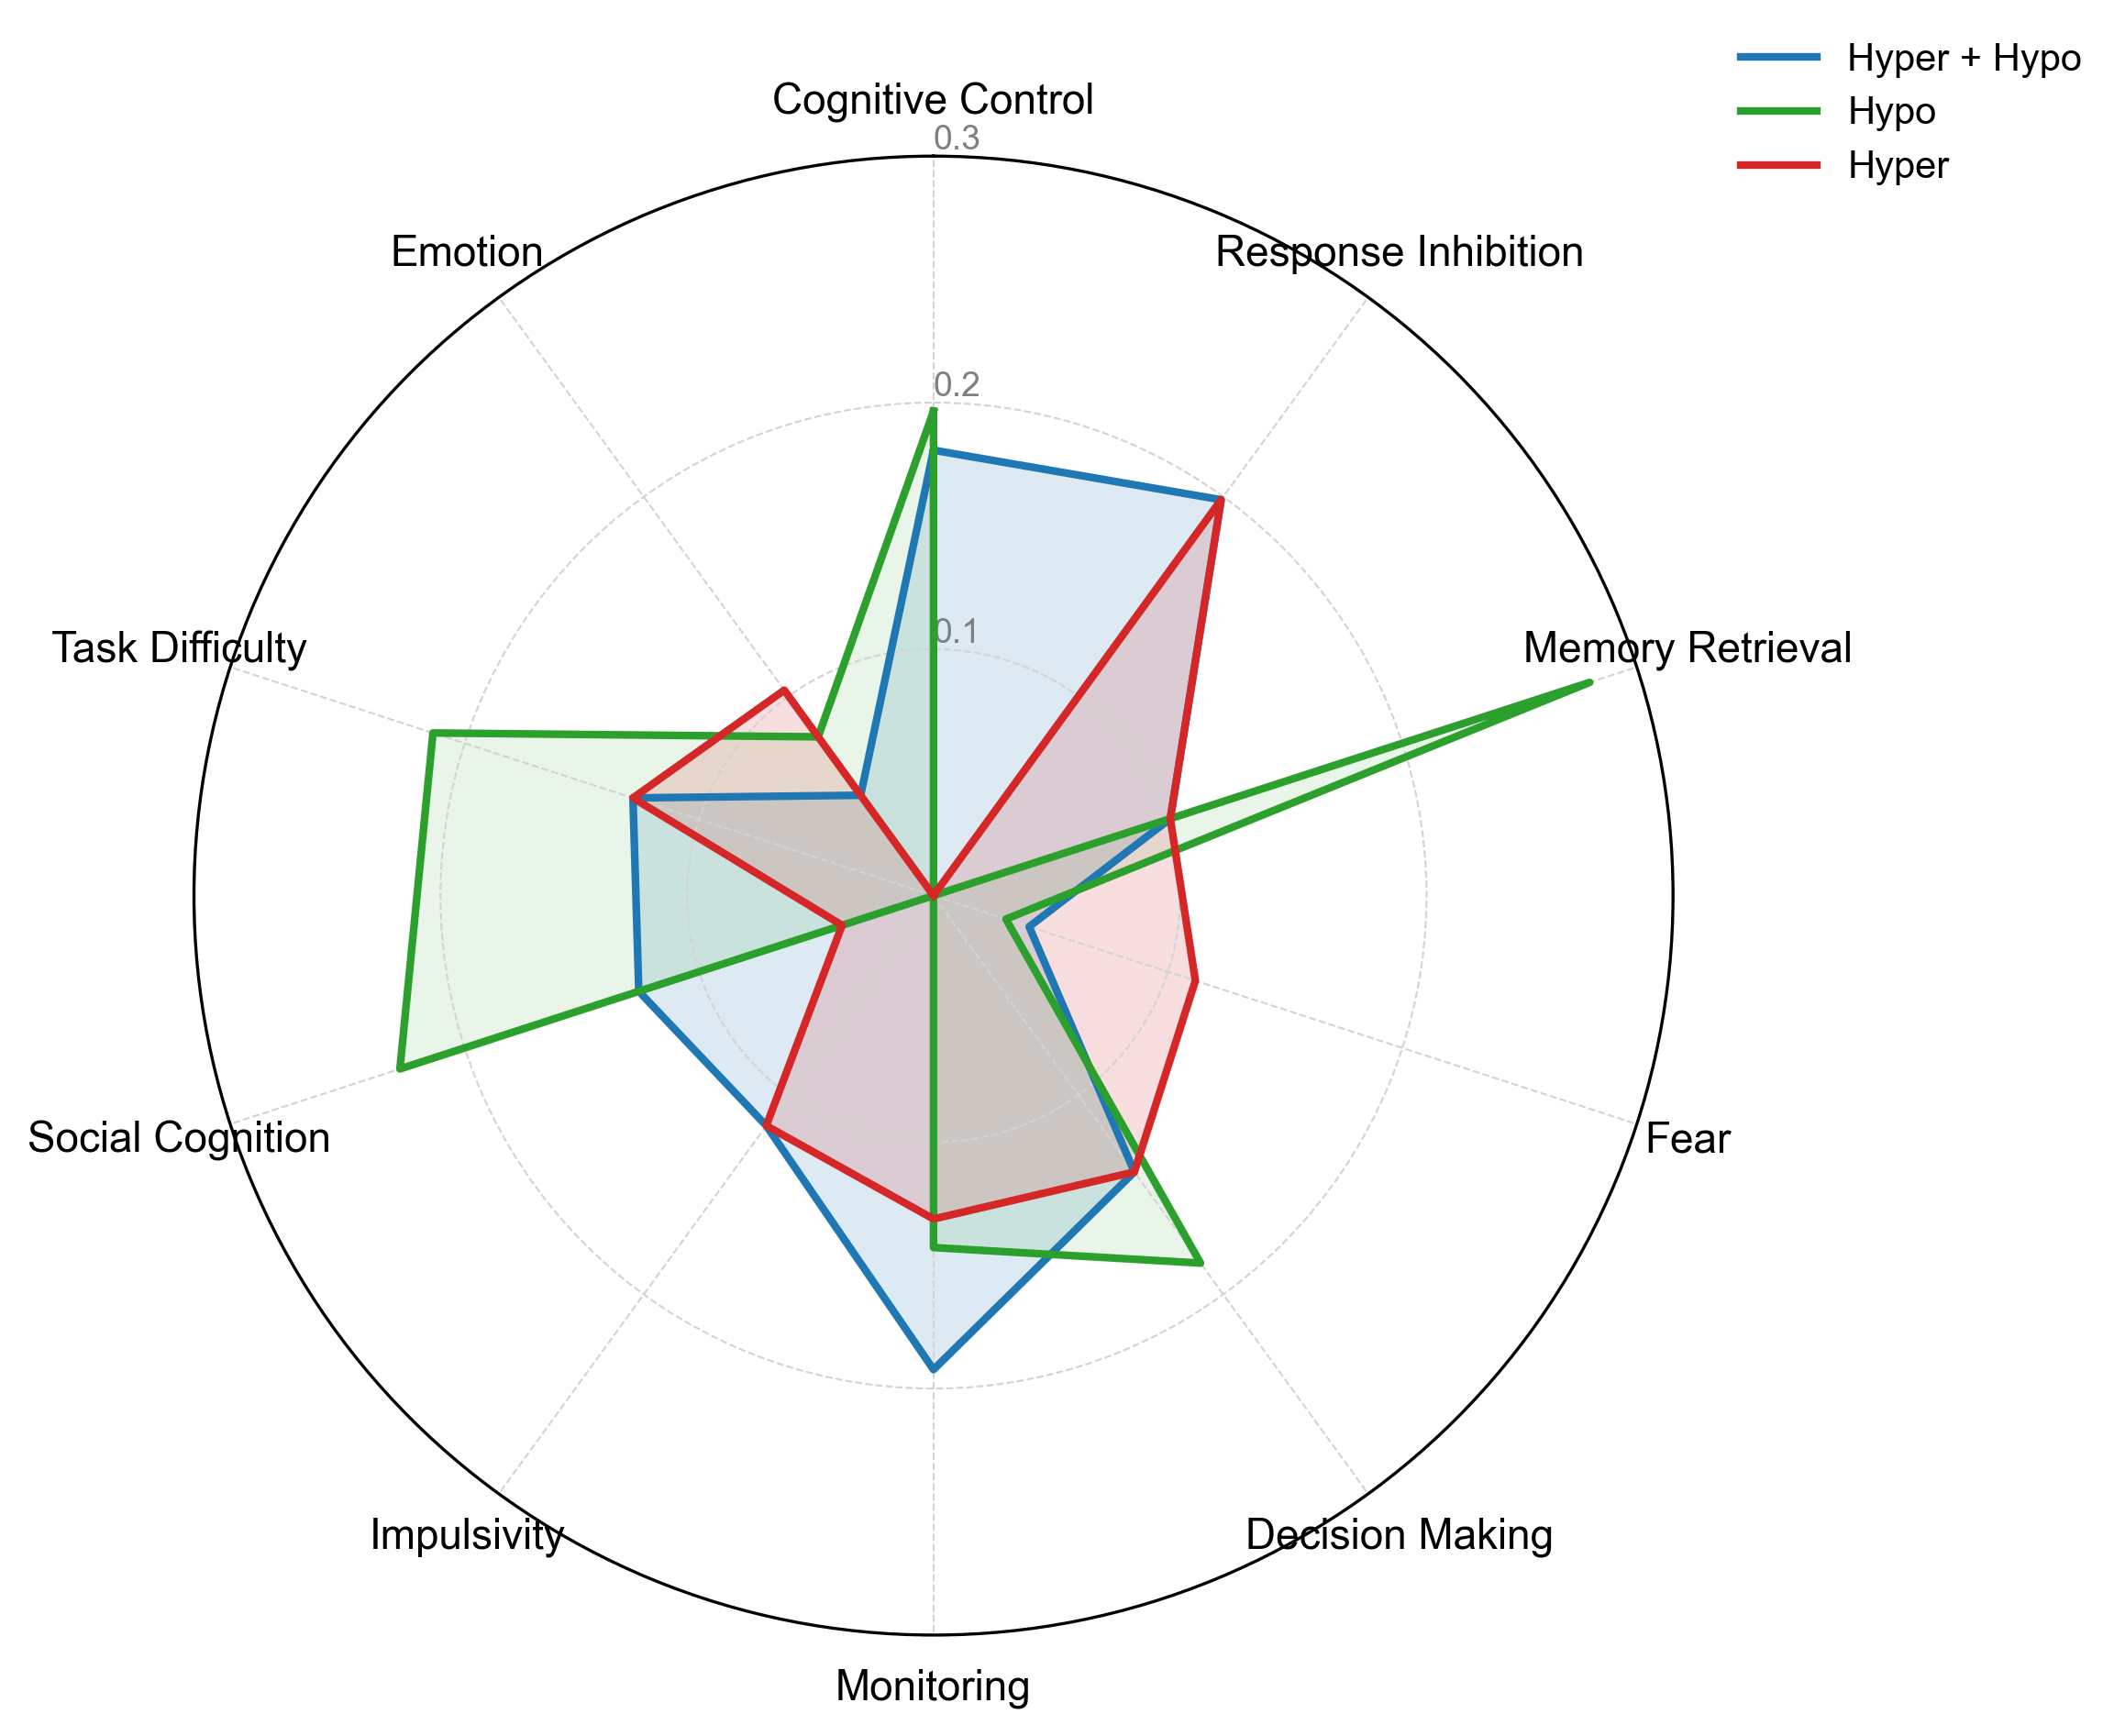

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 设置 SCI 论文常用字体 (如果系统有 Arial 建议使用)
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.unicode_minus'] = False

# 1. 准备数据
labels = [
    'Cognitive Control', 'Response Inhibition', 'Memory Retrieval', 
    'Fear', 'Decision Making', 'Monitoring', 'Impulsivity', 
    'Social Cognition', 'Task Difficulty', 'Emotion'
]

# 数值提取自提供的 CSV
group_a = [0.1807, 0.1985, 0.1010, 0.0408, 0.1386, 0.1923, 0.1154, 0.1257, 0.1282, 0.0503] # Hyper & Hypo
group_b = [0.1965, 0.0000, 0.2799, 0.0309, 0.1843, 0.1428, 0.0000, 0.2276, 0.2135, 0.0796] # Control > Patient
group_c = [0.0000, 0.1985, 0.1010, 0.1117, 0.1386, 0.1312, 0.1154, 0.0390, 0.1282, 0.1030] # Patient > Control

# 闭合曲线
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
group_a += group_a[:1]
group_b += group_b[:1]
group_c += group_c[:1]

# 2. 创建画布 (符合 APA 7 的简洁风格)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True), dpi=300)

# 绘制线条 (配色参考 SCI 常用色系)
ax.plot(angles, group_a, color='#1f77b4', linewidth=2, label='Hyper + Hypo', linestyle='-')
ax.fill(angles, group_a, color='#1f77b4', alpha=0.15)

ax.plot(angles, group_b, color='#2ca02c', linewidth=2, label='Hypo', linestyle='-')
ax.fill(angles, group_b, color='#2ca02c', alpha=0.1)

ax.plot(angles, group_c, color='#d62728', linewidth=2, label='Hyper', linestyle='-')
ax.fill(angles, group_c, color='#d62728', alpha=0.15)

# 3. 设置坐标轴与标签
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# 设置刻度线标签
plt.xticks(angles[:-1], labels, color='black', size=11)

# 设置径向轴刻度 (r轴)
ax.set_rlabel_position(0)
plt.yticks([0.1, 0.2, 0.3], ["0.1", "0.2", "0.3"], color="grey", size=9)
plt.ylim(0, 0.3)

# 4. 图例与排版 (APA 7 建议将图例放在下方或清晰处)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), frameon=False, fontsize=10)

# 去掉多余的背景色
ax.set_facecolor('white')
ax.grid(color='lightgrey', linestyle='--', linewidth=0.5)

plt.tight_layout()

# 保存为高质量图片供论文使用
# plt.savefig('Functional_Decoding_Radar_APA7.png', dpi=600, bbox_inches='tight')
plt.show()